In [3]:
path ="/Users/user/Documents/semster_c/courses/lab/magnetisem/extension2/termo/balanced"
d = lab_tools.read_to_dict(path)

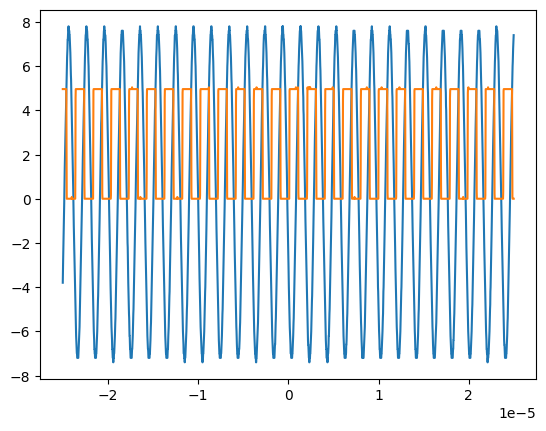

In [8]:
p = d['100']

In [ ]:
lab_tools.find